In [1]:
# Activate the library
import Pkg
Pkg.activate("../")

  Activating project at `~/Documents/Research/MonitoringMetrology/QuTaM.jl`


In [15]:
# Import all the necessary libraries
libraries = ["QuTaM", "LinearAlgebra", "Statistics", "Random", "QuadGK", "Plots", "LaTeXStrings", "OrdinaryDiffEq"]

function ensure_imports(packages::Vector{String})
    for pkg in packages
        try
            @eval using $(Symbol(pkg))
        catch e
            if e isa ArgumentError && occursin(pkg, e.msg)
                println("Installing $pkg...")
                Pkg.add(pkg)
                @eval using $(Symbol(pkg))
            else
                rethrow(e)
            end
        end
    end
end

ensure_imports(libraries)

# Resonance Fluorescene
We'll consider the model as presented in Wiseman's books (equation 3.31) and Molmer (2012).

In [4]:
function rf_de!(dr, r, p, t)
    gamma = QuTaM.rf_gamma
    delta = QuTaM.rf_delta
    omega = QuTaM.rf_omega
    dr[1] = -0.5*gamma*r[1] - 2*delta*r[2]
    dr[2] = 2*delta*r[1] - 0.5*gamma*r[2] - 2*omega*r[3]
    dr[3] = 2*omega*r[2] - gamma*(r[3] + 1)
end

rf_de! (generic function with 1 method)

In [16]:
sys = QuTaM.rf_sys
params = QuTaM.rf_params

SimulParameters(psi0=ComplexF64[1.0 + 0.0im, 0.0 + 0.0im]
nsamples=75000
seed=1
ntraj=250)
multiplier=4.0
tf=400.0
dt=0.021333333333333333
eps=0.001)

In [17]:
r0 = [0.0; 0.0; -1.0] # Initial Condition
tspan = (0.0, params.tf)
t_given = collect(LinRange(0, params.tf, 1000));

In [18]:
prob = ODEProblem(rf_de!, r0, tspan)
sol = solve(prob, reltol = 1e-6, saveat = t_given); 

In [19]:
# Steady State
gamma = QuTaM.rf_gamma
delta = QuTaM.rf_delta
omega = QuTaM.rf_omega
#r_steady = 1/(gamma^2 + 2*omega^2+4*delta^2) * [-4*delta*omega; 2*omega*gamma;-gamma^2-4*delta^2 ]

0.65

In [20]:
################## Average Simulation ################3
# Now from each trajectory, generate the states the given times
sample_clicks = QuTaM.run_trajectories(sys, params)
ntimes = size(t_given)[1]
sample = zeros(ComplexF64, ntimes, sys.NLEVELS, params.ntraj)
@time begin
    
for n in 1:params.ntraj
    states = QuTaM.evaluate_at_t(t_given, sample_clicks[n], sys,  params.psi0)
    for j in 1:sys.NLEVELS
        for tn in 1:ntimes
            sample[tn, j, n] = states[tn, j]
        end 
    end 
end

end 

Sampling... 100%|████████████████████████████████████████| Time: 0:02:06


  0.851322 seconds (4.88 M allocations: 450.102 MiB, 7.03% gc time)


In [21]:
# Obtain the observable on the sample.
r_sample = zeros(Float64, ntimes, 3, params.ntraj)
sigma = [QuTaM.sigma_x, QuTaM.sigma_y, QuTaM.sigma_z]

@time begin
for j in 1:params.ntraj
    for k in 1:3
        for tn in 1:ntimes
                r_sample[tn, k, j] = dot(sample[tn, :, j], sigma[k] * sample[tn, :, j])   # Drop the extra dimension
        end
    end
end 
end
# Average
r_avg = dropdims(mean(r_sample, dims=3), dims=3);

  0.850184 seconds (7.45 M allocations: 331.154 MiB, 5.73% gc time)


In [22]:
tau_sample = Vector{Float64}()
@time begin
for traj in sample_clicks
    if !isempty(traj)
        #    push!(tau_sample, traj[1].time)
        for click in traj
            push!(tau_sample, click.time)
        end 
    else
        continue
    end 
end 
end

  0.001321 seconds (32.42 k allocations: 1009.328 KiB)


In [11]:
import HypothesisTests, Distributions
struct WTD_rf <: Distributions.ContinuousUnivariateDistribution
    omega::Float64
    gamma::Float64
    
end


function Distributions.support(d::WTD_rf)
    return Distributions.Interval(0, Inf)
end

function Distributions.pdf(d::WTD_rf, tau::Real)
        # Replace with your custom formula
        gamma = d.gamma
        omega = d.omega
        return (16*gamma*omega^2)*exp(-0.5*gamma*tau) * sin(0.25*tau*sqrt(16*omega^2-gamma^2))^2/(-gamma^2+16*omega^2)
    end

function Distributions.cdf(d::WTD_rf, t::Real)
    pdf(tau) = (16*gamma*omega^2)*exp(-0.5*gamma*tau) * sin(0.25*tau*sqrt(16*omega^2-gamma^2))^2/(-gamma^2+16*omega^2)
    return quadgk(pdf, 0, t, rtol=1e-8)[1]
end 


function Base.rand(rng::AbstractRNG, d::WTD_rf)
    # Use inversion sampling
    alpha = rand() 
    t = 0
    dt = 0.001 # This is a magic number, the point is that this matches the dt in rf_params
    while Distributions.cdf(d, t) < alpha 
        t = dt + t
    end 
    return t  # Return a sample
end

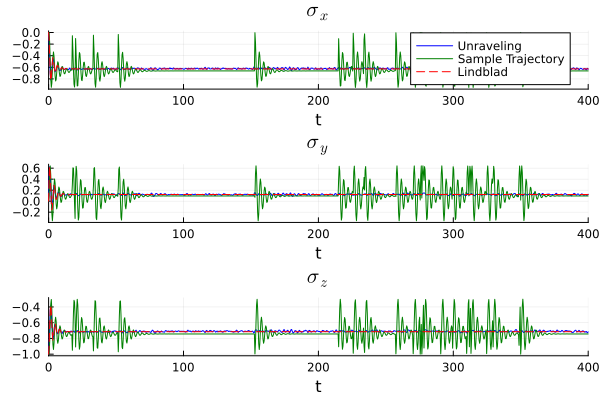

In [36]:
p1 = plot(t_given, r_avg[:, 1], label="Unraveling", title=L"\sigma_x", seriescolor=:blue)
plot!(t_given, r_sample[:,1, 1], label="Sample Trajectory", seriescolor=:green)
plot!(sol, idxs =(0, 1), label="Lindblad", seriescolor=:red, line=:dash)

p2 = plot(t_given, r_avg[:, 2], title=L"\sigma_y", seriescolor=:blue)
plot!(t_given, r_sample[:,2, 1], seriescolor=:green)
plot!(sol, idxs =(0, 2),  legend=false,  seriescolor=:red, line=:dash)

p3 = plot(t_given, r_avg[:, 3], title=L"\sigma_z", seriescolor=:blue)
plot!(t_given, r_sample[:,3, 1],  seriescolor=:green)
plot!(sol, idxs =(0, 3), legend=false, seriescolor=:red, line=:dash)

plot(p1, p2, p3, layout=(3,1))


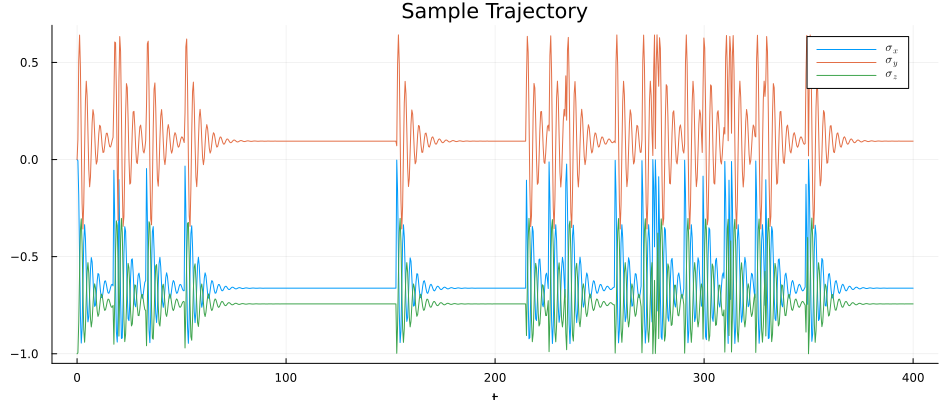

In [43]:
plot(t_given, [r_sample[:,1, 1], r_sample[:,2, 1], r_sample[:,3, 1]], label= [L"\sigma_x" L"\sigma_y" L"\sigma_z"])
plot!(title="Sample Trajectory", xlabel="t", size=(950,400))

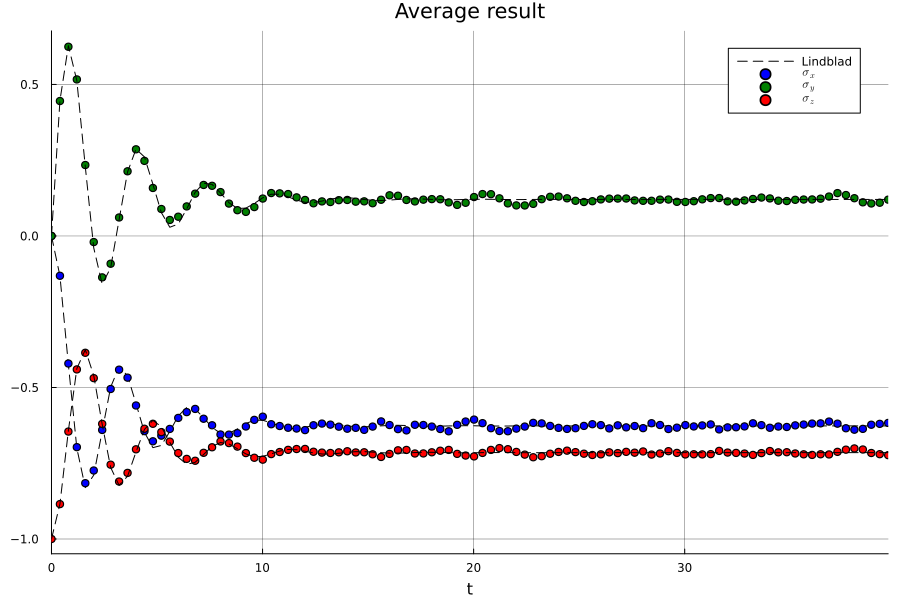

In [68]:
index_range = 1:100

plot(sol[index_range], idxs =(0, 1), seriescolor="black", label="Lindblad",  line=:dash)
scatter!(t_given[index_range], r_avg[index_range, 1],  label=L"\sigma_x" , seriescolor=:blue)

scatter!(t_given[index_range], r_avg[index_range, 2],  label=L"\sigma_y" , seriescolor=:green)
plot!(sol[index_range], idxs =(0, 2), seriescolor="black", label=:false,  line=:dash)

scatter!(t_given[index_range], r_avg[index_range, 3],  label=L"\sigma_z" , seriescolor=:red)
plot!(sol[index_range], idxs =(0, 3), seriescolor="black", label=:false,  line=:dash)

plot!(title="Average result", xlabel="t", grid=:true, gridalpha=0.6, size=(900,600))